In [1]:
%env PYTHONWARNINGS=ignore

env: PYTHONWARNINGS=ignore


# Process Receiver Functions

This notebook does the main processing of the measured receiver functions.
The processing includes

1. Quality filtering
2. Measuring of $P$-to-$S$ sediment basement conversion delay time $t_{PS_b}$
3. Measuring of the two-way travel-time of shear waves in the sediment layer $t_2$

In [2]:
import rf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime
from datetime import datetime
from collections import defaultdict
import pygmt
import random
from joblib import Parallel, delayed
from scipy.signal import argrelmax, argrelmin, correlate
from scipy.stats import expon

from utils import australia_basemap

import warnings

warnings.filterwarnings("ignore")

## Load RFs and QC

In [3]:
try:
    dataroot = os.environ["DATADIR"]
except KeyError:
    dataroot = os.path.join("..", "data","rf_data")

In [4]:
def quality_filter(stream: rf.RFStream) -> rf.RFStream:
    """
    Applies various final quality controls to the RFs
    """
    rf_station_dict = defaultdict(rf.RFStream)
    for trace in stream:
        # Only keep traces where largest arrival is positive
        if trace[np.argmax(np.abs(trace.data))] < 0:
            continue

        # Only keep traces where largest arrival is within 2 seconds after direct P
        largest_arrival = trace.times()[np.argmax(trace.data)] - (
            trace.stats.onset - trace.stats.starttime
        )
        if largest_arrival > 2 or largest_arrival < 0:
            continue

        rf_station_dict[trace.stats.station] += rf.RFStream([trace])

    # Only keep stations with 10 or more traces
    rf_station_dict = {
        k: v.sort(["back_azimuth"]) for k, v in rf_station_dict.items() if len(v) >= 10
    }

    return sum(rf_station_dict.values(), start=rf.RFStream())


def load_network_rfs(network: str):
    """
    Loads the rfs for a network and performs some initial quality filtering
    Returns a stream for the network that has been trimmed and moveout corrected and a count of how many stations and traces were recorded BEFORE any quality control
    """
    network_dir = os.path.join(dataroot, f"{network}-analysis")
    try:
        latest_run = max(
            [
                os.path.join(network_dir, d)
                for d in os.listdir(network_dir)
                if os.path.isdir(os.path.join(network_dir, d)) and d != "corrections"
            ],
            key=os.path.getmtime,
        )
    except ValueError as e:
        print(f"No run found for network {network}.")
        return (network, 0, 0)

    # Grab the output of hiperseis QC <NET>_rf_qc.h5
    h5_file = os.path.join(latest_run, f"{network}_rf_qc.h5")
    if h5_file.split(os.path.sep)[-1] not in os.listdir(latest_run):
        print(f"No run found for network {network}.")
        return (network, 0, 0)

    try:
        stream = rf.read_rf(h5_file, format="h5")
    except:
        print(f"Something went wrong when reading {h5_file}. Moving on...")
        return (network, 0, 0)
    # Drop transverse component
    stream = stream.select(channel="??R")

    # Trim to a reasonable time length
    starttime = -5
    endtime = 10
    stream = stream.trim2(starttime, endtime, reftime="onset")

    stream.moveout()

    # Count initial number of stations and traces
    nstations = len(set([trace.stats.station for trace in stream]))
    ntraces = len(stream)

    # Apply quality filter
    stream = quality_filter(stream)
    if len(stream) == 0:
        print(f"Nothing left after quality control for network {network}. Moving on...")
        return (network, nstations, ntraces)

    return (stream, nstations, ntraces)

Load all the networks in parallel

In [5]:
networks = [
    net[:2]
    for net in os.listdir(dataroot)
    if len(net.split("-")[0]) == 2 and net.split("-")[1] == "analysis"
]

result = Parallel(n_jobs=-1)(delayed(load_network_rfs)(net) for net in networks)
rfstream = rf.RFStream()  # Stream with every RF
init_nstations = {}
init_ntraces = {}
for res in result:
    _netstream, _nstations, _ntraces = res
    if isinstance(_netstream, rf.RFStream):
        net = _netstream[0].stats.network
        rfstream += _netstream
    elif isinstance(_netstream, str):
        net = _netstream
    init_nstations[net] = _nstations
    init_ntraces[net] = _ntraces
del result

Nothing left after quality control for network IU. Moving on...
Nothing left after quality control for network II. Moving on...


Remove traces with exeedingly large amplitudes that will dominate the stacks

In [6]:
log10_amp_max = np.array([tr.stats.log10_amp_max for tr in rfstream])
mean = np.mean(log10_amp_max)
stddev = np.std(log10_amp_max)
normed = (log10_amp_max - mean) / stddev
amplitude_threshold = 4  # in units of stddev
indices = np.where(np.abs(normed) <= amplitude_threshold)[0]
rfstream = rf.RFStream(map(rfstream.__getitem__, indices))

Count remaining stations and traces

In [7]:
empty_networks = []
for net in networks:
    stream = rfstream.select(network=net)
    nstations = len(set([trace.stats.station for trace in stream]))
    ntraces = len(stream)
    print(f"{net}: {nstations}/{init_nstations[net]} stations kept after quality control")
    print(f"{net}: {ntraces}/{init_ntraces[net]} radial RFs kept after quality control")
    if nstations == 0 or ntraces == 0:
        empty_networks.append(net)
for empty in empty_networks:
    networks.remove(empty)

7E: 3/6 stations kept after quality control
7E: 30/65 radial RFs kept after quality control
7D: 6/7 stations kept after quality control
7D: 84/120 radial RFs kept after quality control
1Q: 78/87 stations kept after quality control
1Q: 4107/5624 radial RFs kept after quality control
1P: 22/24 stations kept after quality control
1P: 1425/2243 radial RFs kept after quality control
4J: 48/52 stations kept after quality control
4J: 2826/4294 radial RFs kept after quality control
3G: 62/65 stations kept after quality control
3G: 3705/4628 radial RFs kept after quality control
S1: 16/43 stations kept after quality control
S1: 372/701 radial RFs kept after quality control
6C: 16/16 stations kept after quality control
6C: 770/1028 radial RFs kept after quality control
1E: 16/16 stations kept after quality control
1E: 618/814 radial RFs kept after quality control
ZR: 51/52 stations kept after quality control
ZR: 3577/4410 radial RFs kept after quality control
5G: 39/40 stations kept after qualit

In [8]:
print(f"Networks {', '.join(empty_networks)} have no more traces after quality control")

Networks IU, II have no more traces after quality control


## Measure delay time

In [9]:
def get_tpsb(trace: rf.rfstream.RFTrace):
    """
    Finds the time of the first local maximum of trace.
    The pre-arrival part of the trace will have loads of little local maxima.
    Need to get the first maximum post P-onset
    """
    inds = argrelmax(trace.data)[0]
    p_arrival_ind = int(trace.stats.sampling_rate * (trace.stats.onset - trace.stats.starttime))
    ind = inds[np.searchsorted(inds >= p_arrival_ind, True)]
    return trace.times()[ind] - (trace.stats.onset - trace.stats.starttime)

In [10]:
def station_stack(stream: rf.RFStream) -> rf.RFStream():
    """
    TO BE USED ONLY WHEN STREAM ONLY CONTAINS TRACES FROM THE SAME STATION
    RFStream.stack() forces stacking for separate ids, including channels
    Access original obspy Stream.stack() to stack BHR and HHR channels
    Copies meta data as in RFStream.stack()
    """
    _stream = stream.copy()  # Stream.stack() operates in place
    stack = super(rf.RFStream, _stream).stack(group_by="{network}.{station}")
    assert len(stack) == 1
    tr = stream[0]
    data = stack[0].data
    header = {}
    for entry in (
        "network",
        "station",
        "sampling_rate",
        "phase",
        "moveout",
        "station_latitude",
        "station_longitude",
        "station_elevation",
        "processing",
    ):
        if entry in tr.stats:
            header[entry] = tr.stats[entry]
    _tr = rf.rfstream.RFTrace(data=data, header=header)
    if "onset" in tr.stats:
        onset = tr.stats.onset - tr.stats.starttime
        _tr.stats.onset = _tr.stats.starttime + onset
    return rf.RFStream(_tr)


def stack_by_station(stream: rf.RFStream) -> rf.RFStream():
    # Station dictionary
    rf_station_dict = defaultdict(rf.RFStream)
    for trace in stream:
        rf_station_dict[
            ".".join([trace.stats.network, trace.stats.station])
        ] += rf.RFStream([trace])

    # stack stations individually, otherwise station coordinates also get stacked
    stacks = rf.RFStream()
    for v in rf_station_dict.values():
        stacks += station_stack(v)

    return stacks


def get_delays(stream: rf.RFStream) -> rf.RFStream():
    # Get delay of each stack
    for stack in stream:
        delay = get_tpsb(stack)
        if delay >= 0:
            stack.stats["delay"] = delay
        else:
            print(
                f"Negative delay obtained for {stack.stats.network}.{stack.stats.station}"
            )
            stream.remove(stack)

    return stream.sort(["delay", "network", "station"])

In [11]:
rfstacks = stack_by_station(rfstream)  # stream with station stacks
rfstacks = get_delays(rfstacks)

Plot traces, stacks and maps

In [12]:
def plot_map(stream: rf.RFStream, save_dir: str=".", show: bool=False):
    lats = np.array([trace.meta.station_latitude for trace in stream])
    lons = np.array([trace.meta.station_longitude for trace in stream])
    delays = np.array([trace.meta.delay for trace in stream])

    fig, region, projection = australia_basemap()
    pygmt.makecpt(cmap="hot", truncate=[0, 0.8], series=[0, 1, 0.1],background="o", reverse=True)
    fig.plot(
        region=region,
        projection=projection,
        x=lons,
        y=lats,
        style=f"tc",
        fill=delays,
        cmap=True,
        size=np.full_like(lons, 0.25),
    )
    fig.colorbar(
        region=region,
        projection=projection,
        frame=["af+lDelay Time TPsb (s)", f"y+lmax={delays.max():.2f}"],
        position="JBC+ef",
    )
    if save_dir is not None:
        mapfile = os.path.join(save_dir, "delay_map.pdf")
        fig.savefig(mapfile)
    if show:
        fig.show()

In [13]:
dry_run = False
if not dry_run:
    # Make output directories
    now = (datetime.now()).strftime(format="%Y%m%d_%H%M%S")
    processedroot = os.path.join(dataroot, "..", "processed")

    for net in networks:
        os.makedirs(os.path.join(processedroot, now, net))


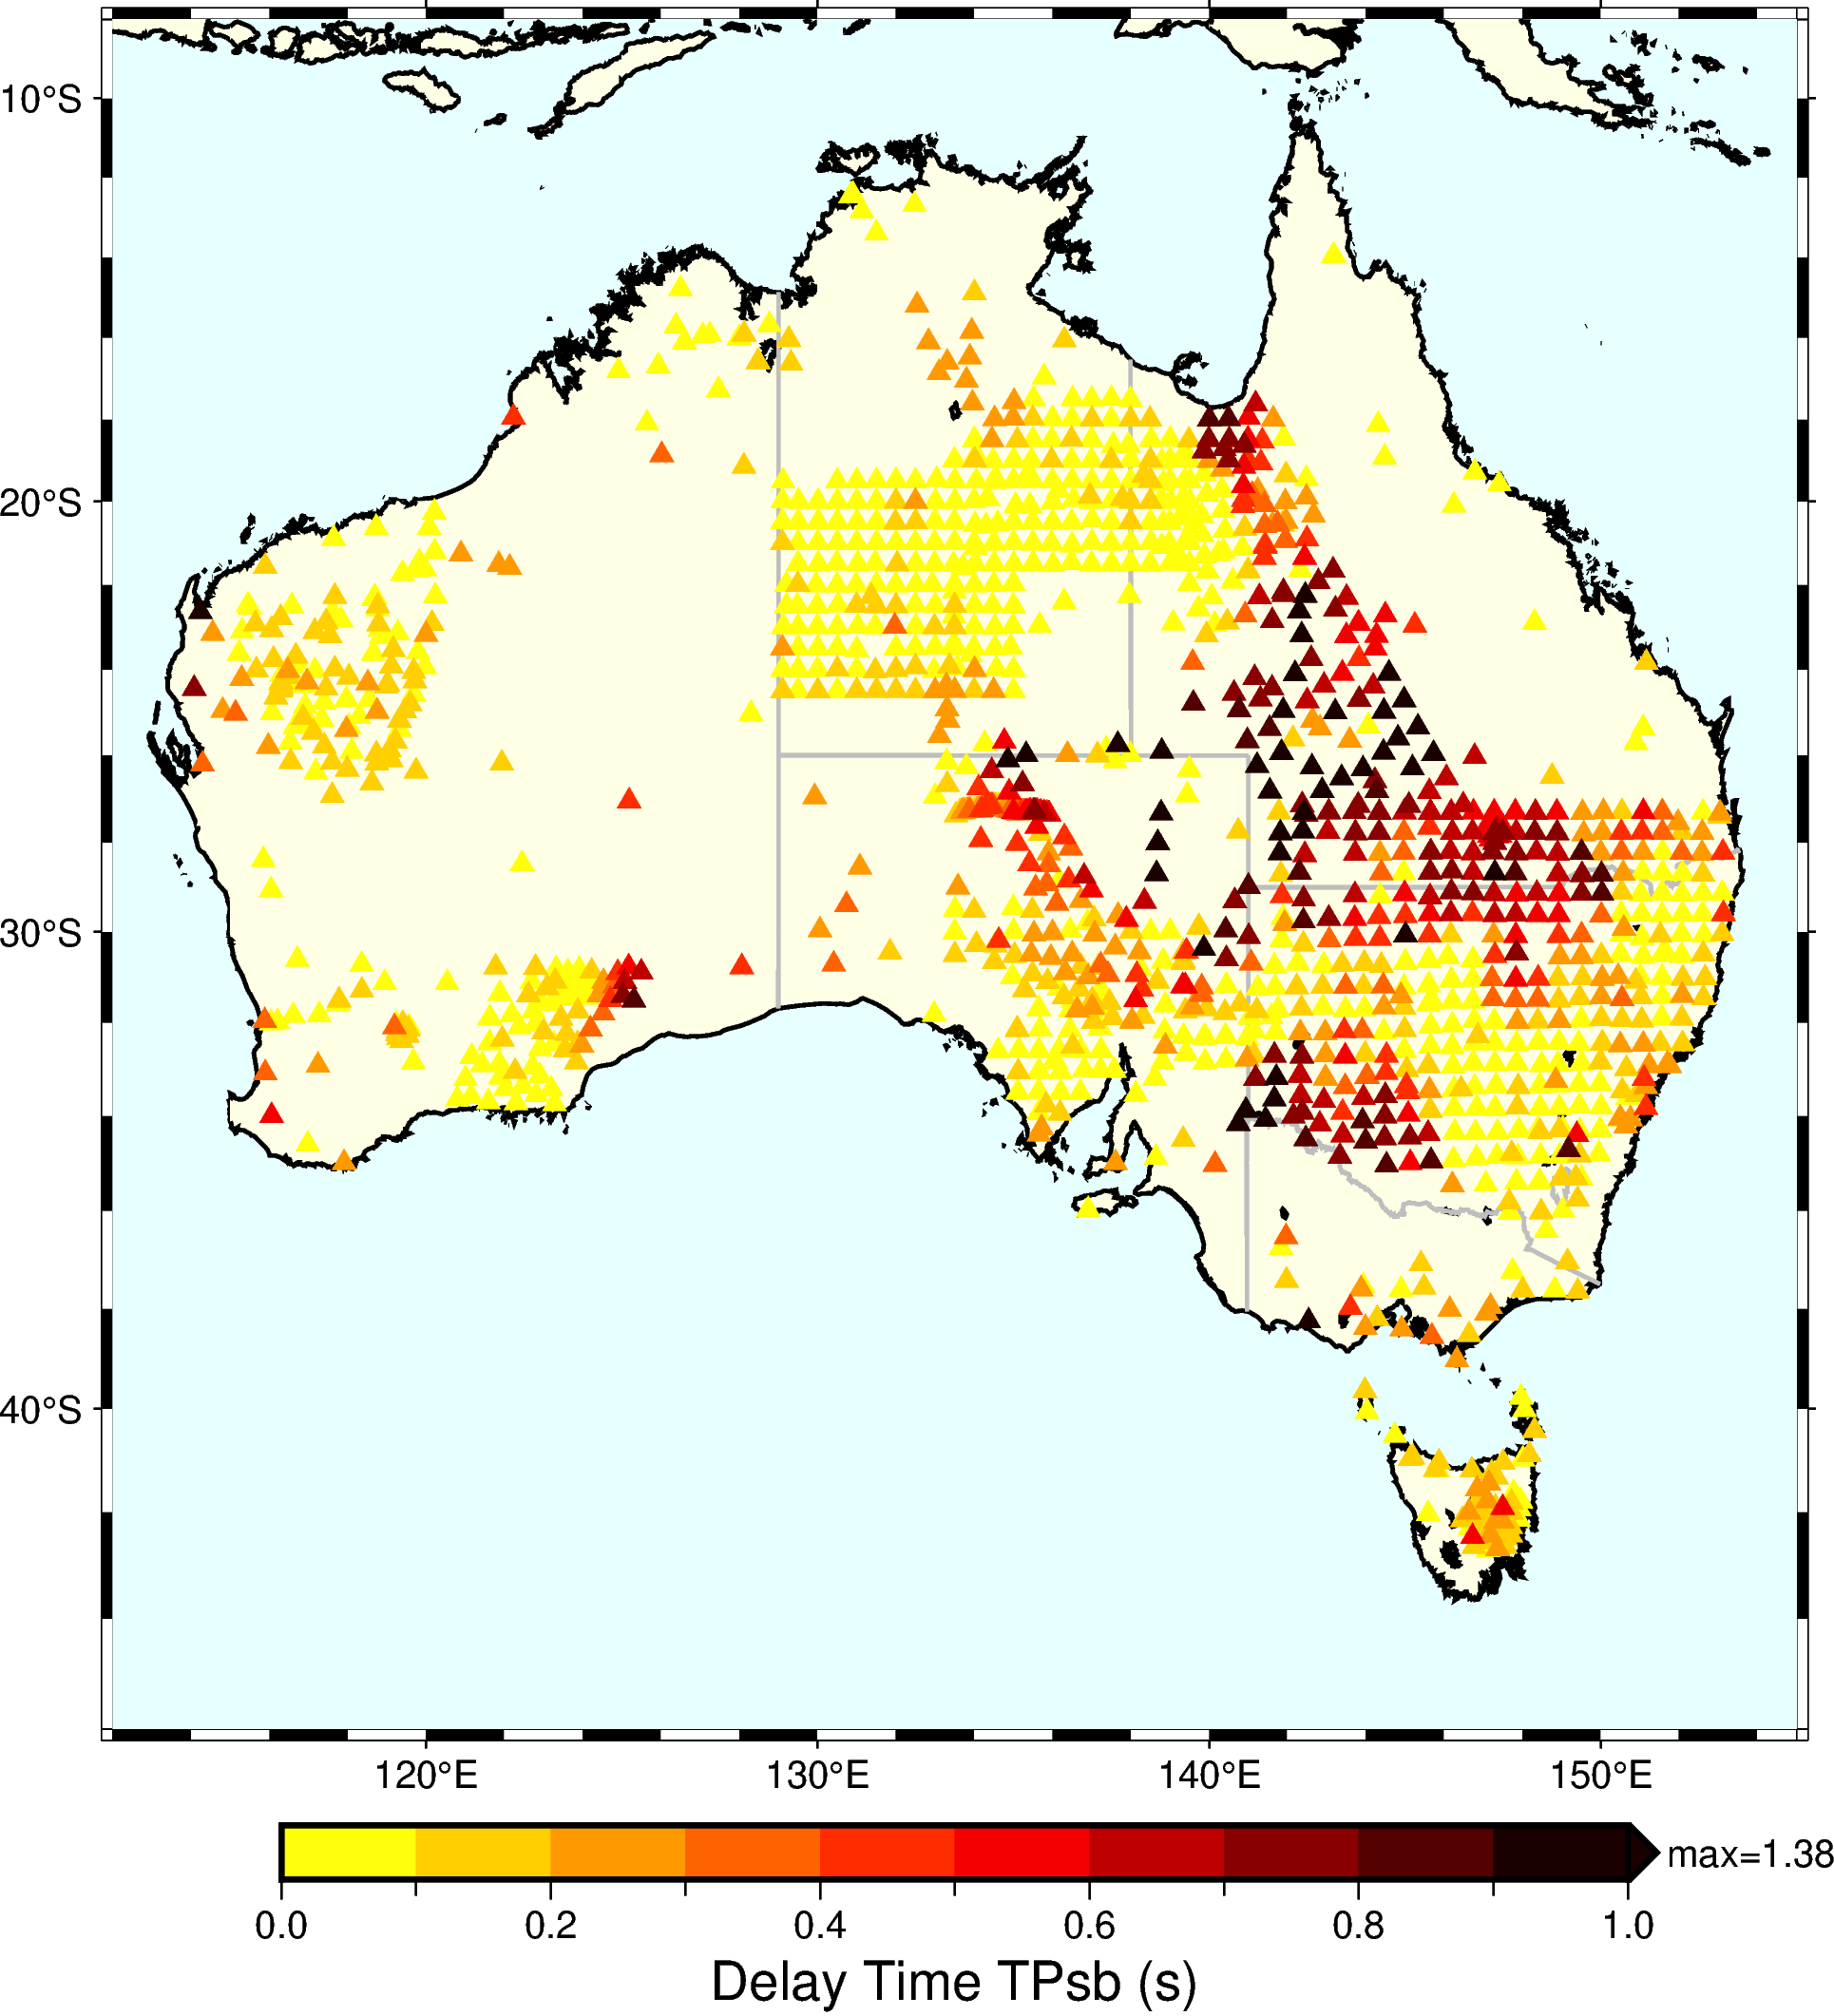

In [14]:
if not dry_run:
    def plot_rfs_stacks_map(network, stream, stacks):
        outdir = os.path.join(processedroot, now, network)
        stations = set([stack.stats.station for stack in stacks])
        # plot RFs at each station
        for station in stations:
            rfs = stream.select(station=station)
            plot_name = os.path.join(outdir, f"{station}.pdf")
            rfs.plot_rf(
                fname=plot_name,
                fig_width=4,
                fillcolors=("green", None),
                trace_height=0.1,
                scale=3,
                show_vlines=True,
                trim=(-2, 6),
            )  # this figure needs some bits to be moved around

        # Plot the stacked RFs of the network
        plot_name = os.path.join(outdir, f"stacks.pdf")
        stacks.plot_rf(
            fname=plot_name,
            fig_width=4,
            fillcolors=("green", None),
            trace_height=0.1,
            scale=3,
            show_vlines=True,
            trim=(-2, 6),
            info=(),
        )  # customise this plot to use a colourmap

        # Plot map of network delay times
        plot_map(stacks, outdir)


    # Plots for each network
    Parallel(n_jobs=-1)(
        delayed(plot_rfs_stacks_map)(
            net, rfstream.select(network=net), rfstacks.select(network=net)
        ) for net in networks
    )

    # Plot the full map
    outdir = os.path.join(processedroot, now)
    plot_map(rfstacks, outdir, show=True)

Save the final RFs and stacks

In [15]:
if not dry_run:
    rfstream.write(os.path.join(outdir, "rfstream.h5"), format="H5")
    rfstacks.write(os.path.join(outdir, "rfstacks.h5"), format="H5")

## Measure two-way travel-time

In [16]:
def get_twowaytraveltime(autocorrelation: rf.rfstream.RFTrace):
    """
    Picks out the first local minimum of a radial RF autocorrelation.
    The autocorrelation should start at t=0 i.e. the latter half of the full autocorrelation
    """
    ind = argrelmin(autocorrelation.data)[0][0]
    autocorrelation.stats["twtt"] = ind / autocorrelation.stats.sampling_rate
    return autocorrelation

Create streams of the autocorrelations of all rfs and stacks

In [17]:
def autocorrelate_stream(stream: rf.RFStream) -> rf.RFStream:
    autocorrelations = stream.copy()
    for tr in autocorrelations:
        auto = correlate(tr.data, tr.data, mode="full")
        auto /= auto.max()
        auto = auto[auto.size // 2 :]
        tr.data = auto
    return autocorrelations 

In [18]:
autostacks = autocorrelate_stream(rfstacks)
autostream = autocorrelate_stream(rfstream)

Measure the two-way travel-time for each individual trace.

In [19]:
result = Parallel(n_jobs=4)(
    delayed(get_twowaytraveltime)(auto) for auto in autostream
)
autostream = rf.RFStream(result)

Plot the autocorrelations and picked two-way travel-time for each station

In [20]:
def plot_autos(autos: rf.RFStream):
    Dt = np.array([a.stats["twtt"] for a in autos])
    Dt_ind = np.array([int(a.stats["twtt"] * a.stats.sampling_rate) for a in autos], dtype=int)
    r0 = np.array([a[i] for a, i in zip(autos, Dt_ind)])
    _autos = np.array([auto.data for auto in autos])

    n_autos = len(autos)
    fig_w = 5
    fig_h = n_autos * 0.125
    fig, ax = plt.subplots(1, 1, figsize=(fig_w, fig_h))
    t = autos[0].times()
    levels = np.arange(n_autos)
    ax.plot(t, _autos.T + levels[np.newaxis, :], "k")
    ax.scatter(Dt, levels + r0, c="r")
    station = autos[0].meta.station
    network = autos[0].meta.network
    ax.set_title(f"{n_autos} Traces {'.'.join([network, station])}")

    outdir = os.path.join(processedroot, now, network)
    fig.savefig(os.path.join(outdir, f"{station}_autos.pdf"))
    plt.close()

In [21]:
auto_station_dict = defaultdict(rf.RFStream)
for trace in autostream:
    auto_station_dict[
        ".".join([trace.stats.network, trace.stats.station])
    ] += rf.RFStream([trace])

In [22]:
if not dry_run:
    _ = Parallel(n_jobs=4)(delayed(plot_autos)(autos) for autos in auto_station_dict.values())

Create an initial map.  Take the mean $t_2$ at each station.  For now there is no checking for unusually small or large values

In [23]:
for _id, autos in auto_station_dict.items():
    net, sta = _id.split(".")
    t2 = np.median([auto.stats.twtt for auto in autos])
    autostacks.select(network=net, station=sta)[0].stats["twtt"] = t2

In [24]:
def plot_map(stream: rf.RFStream, save_dir: str=".", show: bool=False):
    lats = np.array([trace.meta.station_latitude for trace in stream])
    lons = np.array([trace.meta.station_longitude for trace in stream])
    t2s = np.array([trace.meta.twtt for trace in stream])

    fig, region, projection = australia_basemap()
    pygmt.makecpt(cmap="hot", truncate=[0, 0.8], series=[1, 2, 0.1],background="o", reverse=True)
    fig.plot(
        region=region,
        projection=projection,
        x=lons,
        y=lats,
        style=f"tc",
        fill=t2s,
        cmap=True,
        size=np.full_like(lons, 0.25),
    )
    fig.colorbar(
        region=region,
        projection=projection,
        frame=["af+lTwo-way Travel-time (s)", f"y+lmax={t2s.max():.2f}"],
        position="JBC+e",
    )
    if save_dir is not None:
        mapfile = os.path.join(save_dir, "twtt_map.pdf")
        fig.savefig(mapfile)
    if show:
        fig.show()

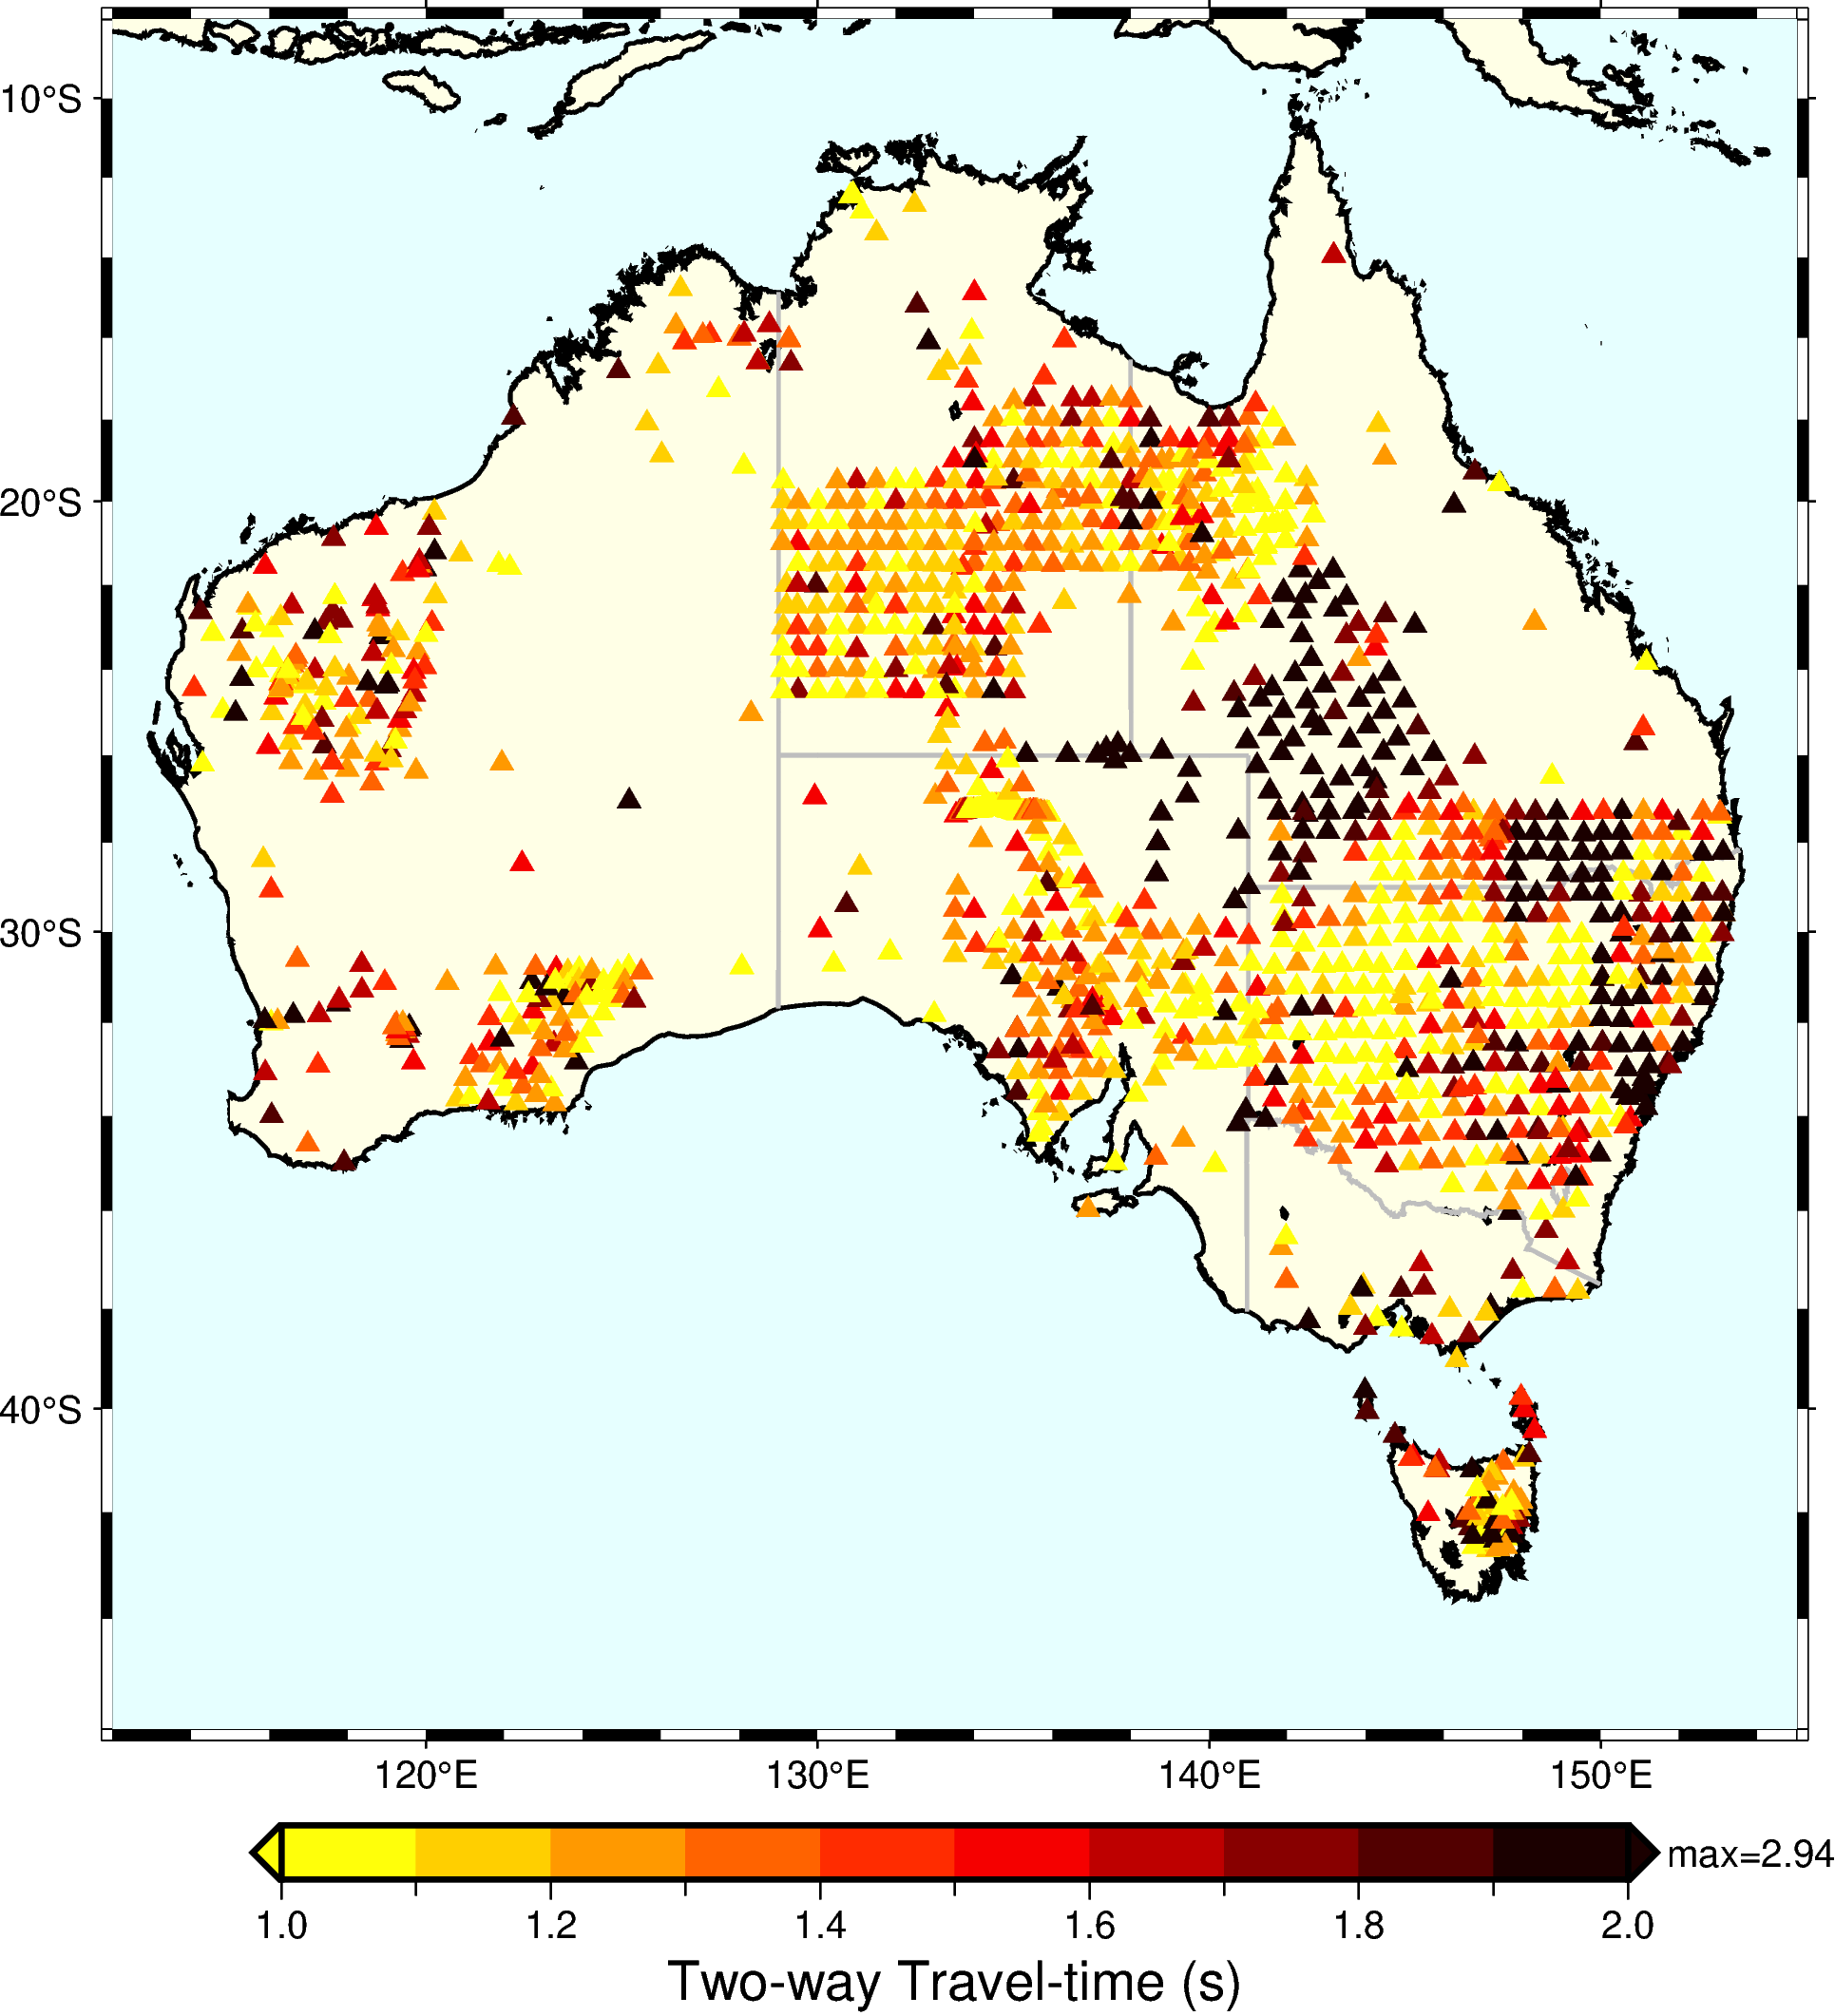

In [25]:
plot_map(autostacks, outdir, show=True)

Save autocorrelations

In [ ]:
if not dry_run:
    autostream.write(os.path.join(outdir, "autostream.h5"), format="H5")